In [15]:
import glob
import json
import pandas as pd

# Define the file pattern to find JSON files
file_pattern = "DevGPT/snapshot_*/**/*_issue_sharings.json"

# Get all matching file paths
file_paths = glob.glob(file_pattern, recursive=True)

# Define categories for issue classification
categories = {
    'Bug': ['bug', 'error', 'issue', 'fix', 'debug'],
    'Feature Request': ['feature', 'request', 'add', 'implement', 'enhance'],
    'Theoretical Question': ['concept', 'theory', 'explain', 'understand', 'definition'],
    'Optimization': ['optimize', 'performance', 'speed', 'efficient', 'improve']
}

# Function to classify issues based on title
def classify_issue(title):
    for category, keywords in categories.items():
        if any(keyword.lower() in title.lower() for keyword in keywords):
            return category
    return 'Other'

# Initialize a list to store DataFrames for later merging (optional)
combined_dfs = []

# Loop through each file and process
for file_path in file_paths:
    try:
        # Load JSON file
        with open(file_path, 'r') as file:
            data = json.load(file)
        
        # Flatten the JSON structure
        df = pd.json_normalize(
            data["Sources"],
            record_path=["ChatgptSharing"],  # Path to nested data
            meta=["Author"],  # Include top-level metadata
            sep="_"
        )
        
        # Convert date columns to datetime
        df['DateOfConversation'] = pd.to_datetime(df.get('DateOfConversation'), errors='coerce')
        df['DateOfAccess'] = pd.to_datetime(df.get('DateOfAccess'), errors='coerce')
        
        # Handle missing values in 'Title'
        df['Title'] = df['Title'].fillna('Unknown')
        
        # Classify issues based on 'Title'
        df['IssueType'] = df['Title'].apply(classify_issue)
        
        # Save individual file results as CSV
        output_file = file_path.replace(".json", ".csv")
        df.to_csv(output_file, index=False)
        print(f"Processed and saved: {output_file}")
        
        # Optionally store the DataFrame for later merging
        combined_dfs.append(df)
    
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")

# Optional: Combine all DataFrames into one
if combined_dfs:
    combined_data = pd.concat(combined_dfs, ignore_index=True)
    combined_data.to_csv("combined_issue_sharings.csv", index=False)
    print("All files combined and saved as combined_issue_sharings.csv")

Processed and saved: DevGPT/snapshot_20230824/20230824_101836_issue_sharings.csv
Processed and saved: DevGPT/snapshot_20230831/20230831_061759_issue_sharings.csv
Processed and saved: DevGPT/snapshot_20230727/20230727_195941_issue_sharings.csv
Processed and saved: DevGPT/snapshot_20230810/20230810_123938_issue_sharings.csv
Processed and saved: DevGPT/snapshot_20230817/20230817_130502_issue_sharings.csv
Processed and saved: DevGPT/snapshot_20230803/20230803_094705_issue_sharings.csv
All files combined and saved as combined_issue_sharings.csv


In [16]:
df = pd.read_csv('combined_issue_sharings.csv')
df['DateOfConversation'] = pd.to_datetime(df['DateOfConversation'], errors='coerce')
df['DateOfAccess'] = pd.to_datetime(df['DateOfAccess'], errors='coerce')

In [17]:
# Convert to datetime
df['DateOfConversation'] = pd.to_datetime(df['DateOfConversation'], errors='coerce')
df['DateOfAccess'] = pd.to_datetime(df['DateOfAccess'], errors='coerce')

# Handle Missing Values
df.fillna({'Title': 'No Title', 'HTMLContent': ''}, inplace=True)



# Create New Feature: Token Efficiency
df['TokenEfficiency'] = df['TokensOfAnswers'] / df['TokensOfPrompts']

# Save Cleaned Data
df.to_csv('cleaned_data.csv', index=False)

In [18]:
df = pd.read_csv('cleaned_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2089 entries, 0 to 2088
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   URL                        2089 non-null   object 
 1   Status                     2089 non-null   int64  
 2   DateOfConversation         1797 non-null   object 
 3   DateOfAccess               1896 non-null   object 
 4   Title                      2089 non-null   object 
 5   NumberOfPrompts            1896 non-null   float64
 6   TokensOfPrompts            1896 non-null   float64
 7   TokensOfAnswers            1896 non-null   float64
 8   Model                      1632 non-null   object 
 9   Conversations              1896 non-null   object 
 10  HTMLContent                1896 non-null   object 
 11  Mention_MentionedURL       2089 non-null   object 
 12  Mention_MentionedProperty  2089 non-null   object 
 13  Mention_MentionedAuthor    2089 non-null   objec

In [19]:
categories = {
    'Bug': ['bug', 'error', 'issue', 'fix'],
    'Feature Request': ['feature', 'request', 'implement', 'add'],
    'Theoretical Question': ['theoretical', 'concept', 'explain', 'understand'],
    'Optimization': ['optimize', 'performance', 'improve', 'efficient']
}

def classify_issue(title):
    for category, keywords in categories.items():
        if any(keyword.lower() in title.lower() for keyword in keywords):
            return category
    return 'Other'

df['IssueType'] = df['Title'].apply(classify_issue)


print(df['IssueType'].value_counts())

IssueType
Other                   1803
Bug                      197
Feature Request           60
Optimization              23
Theoretical Question       6
Name: count, dtype: int64


IssueType
Other                   1803
Bug                      197
Feature Request           60
Optimization              23
Theoretical Question       6
Name: count, dtype: int64


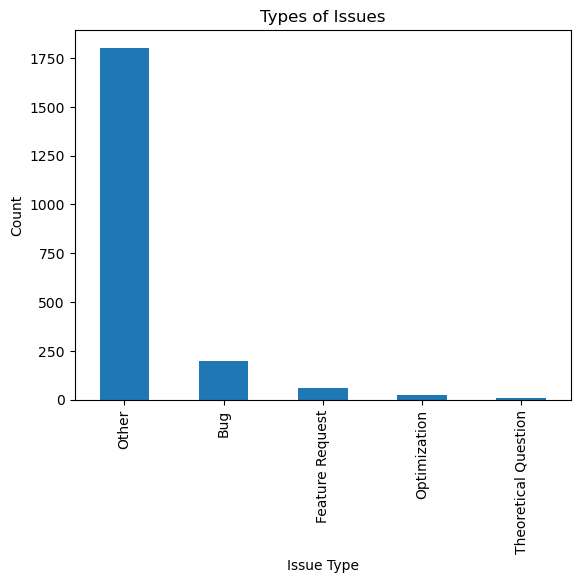

In [20]:

issue_counts = df['IssueType'].value_counts()
print(issue_counts)

import matplotlib.pyplot as plt

issue_counts.plot(kind='bar', title='Types of Issues')
plt.xlabel('Issue Type')
plt.ylabel('Count')
plt.show()

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

# Replace NaN values with an empty string
df['Conversations'] = df['Conversations'].fillna("")

# Ensure all entries in the column are strings
df['Conversations'] = df['Conversations'].astype(str)

# Extract keywords using CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=20)
keywords_matrix = vectorizer.fit_transform(df['Conversations'])

# Get feature names (keywords)
keywords = vectorizer.get_feature_names_out()

# Print extracted keywords
print("Top keywords:", keywords)
pd.DataFrame({"Keywords": keywords}).to_csv("keywords.csv", index=False)

Top keywords: ['answer' 'code' 'code_block_0' 'content' 'data' 'div' 'file' 'id'
 'listofcode' 'model' 'prompt' 'py' 'python' 'replacestring' 'response'
 'return' 'self' 'type' 'use' 'using']


In [22]:
token_summary = df.groupby('IssueType')[['TokensOfPrompts', 'TokensOfAnswers']].mean()
print(token_summary)

                      TokensOfPrompts  TokensOfAnswers
IssueType                                             
Bug                        974.807107      1584.360406
Feature Request           2517.433333      2992.833333
Optimization               604.652174       550.608696
Other                      691.407453      1827.168323
Theoretical Question       295.000000       786.000000


In [23]:
import re
from collections import Counter

# Define patterns for each language
language_patterns = {
    'Python': r'\bdef\b|\bimport\b|\bprint\(',
    'JavaScript': r'\bfunction\b|\bvar\b|\blet\b|\bconsole\.log\(',
    'Java': r'\bpublic class\b|\bSystem\.out\.println\b',
    'HTML': r'<html>|<head>|<body>',
    'CSS': r'\{|\bcolor:\b|\bfont-size\b',
    'SQL': r'\bSELECT\b|\bFROM\b|\bWHERE\b'
}

# Function to detect language
def detect_language(code_snippet):
    for language, pattern in language_patterns.items():
        if re.search(pattern, code_snippet, re.IGNORECASE):
            return language
    return 'Unknown'

# Combine code snippets from relevant columns
code_snippets = df['HTMLContent'].dropna().tolist() + df['Conversations'].dropna().tolist()

# Detect languages
detected_languages = [detect_language(snippet) for snippet in code_snippets]

# Count occurrences of each language
language_counts = Counter(detected_languages)

# Display results
print("Language usage:")
for language, count in language_counts.items():
    print(f"{language}: {count}")

Language usage:
JavaScript: 1854
Python: 1297
Java: 34
CSS: 605
Unknown: 193
HTML: 2


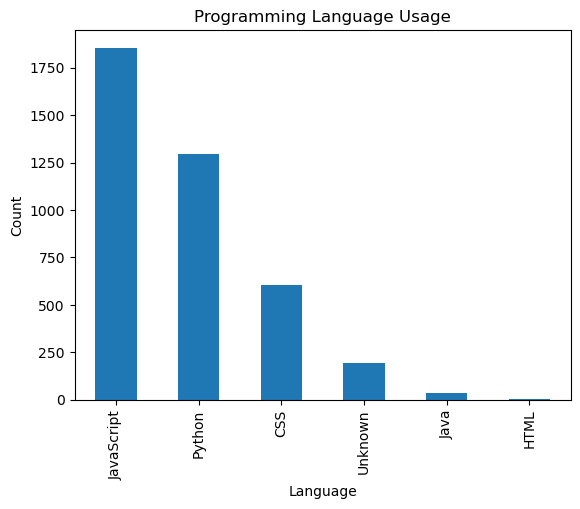

In [24]:
import matplotlib.pyplot as plt

# Convert language counts to DataFrame
language_df = pd.DataFrame(language_counts.items(), columns=['Language', 'Count'])

# Plot bar chart
language_df.sort_values('Count', ascending=False).plot(
    kind='bar', x='Language', y='Count', legend=False, title='Programming Language Usage'
)
plt.ylabel('Count')
plt.show()